### **About the Project**

In this project, I will be performing an unsupervised clustering of data on the customer's records from a grocery firm's database. 

Customer segmentation is the practice of separating customers into groups that reflect similarities among customers in each cluster. I will divide customers into segments to optimize the significance of each customer to the business. 

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/customer-personality-analysis/marketing_campaign.csv


### **Import The Libraries**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from matplotlib import colors
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### **Loading the dataset**

In [3]:
df = pd.read_csv('/kaggle/input/customer-personality-analysis/marketing_campaign.csv',sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### **Understanding The Data**

In [4]:
df.shape

(2240, 29)

The dataset has 2240 rows and 29 columns.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

* There are missing values in the Income column.
* Dt_Customer that indicates the date a customer joined the database is not parsed as DateTime.
* There are some categorical features in our data frame; as there are some features in dtype: object. So we will need to encode them into numeric format later.

### **Feature Engineering**

In [6]:
#First of all, for the missing values, I am simply going to drop the rows that have missing income values.

df = df.dropna()
print("Remaining rows:",len(df))

Remaining rows: 2216


In the next step, I am going to create a feature out of "Dt_Customer" that indicates the number of days a customer is registered in the firm's database. However, in order to keep it simple, I am taking this value relative to the most recent customer in the record.

In [7]:
df['Dt_Customer'] = pd.to_datetime(df["Dt_Customer"])
df['Dt_Customer']

0      2012-04-09
1      2014-08-03
2      2013-08-21
3      2014-10-02
4      2014-01-19
          ...    
2235   2013-06-13
2236   2014-10-06
2237   2014-01-25
2238   2014-01-24
2239   2012-10-15
Name: Dt_Customer, Length: 2216, dtype: datetime64[ns]

In [8]:
dates = []
for i in df["Dt_Customer"]:
    i = i.date()
    dates.append(i)
        

In [9]:
print("The newest record :",max(dates))
print("The oldest record :",min(dates))

The newest record : 2014-12-06
The oldest record : 2012-01-08


In [10]:
days = []
for i in dates:
    delta = max(dates) - i
    delta = int(delta.days)
    days.append(delta)
df["Customer_for"] = days
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Customer_for
0,5524,1957,Graduation,Single,58138.0,0,0,2012-04-09,58,635,...,0,0,0,0,0,0,3,11,1,971
1,2174,1954,Graduation,Single,46344.0,1,1,2014-08-03,38,11,...,0,0,0,0,0,0,3,11,0,125
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,0,0,3,11,0,472
3,6182,1984,Graduation,Together,26646.0,1,0,2014-10-02,26,11,...,0,0,0,0,0,0,3,11,0,65
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,0,0,0,0,3,11,0,321


Rename the columns.

In [11]:
#for clarity rename columns
df = df.rename(columns={'MntWines':'wines','MntFruits':'fruits','MntMeatProducts':'meat','MntFishProducts':'fish','MntSweetProducts':'sweet','MntGoldProds':'gold'})

Let us clean the Education, Marital_Status columns.

In [12]:
df["Education"].value_counts()

Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64

Replace 2n Cycle, Basic by Under Graduate,Graduation by Graduate and Master, PhD by Post Graduate.

In [13]:
df['Education'] = df["Education"].replace({'Basic':'Under Graduate','2n Cycle':'Under Graduate','Graduation':'Graduate','Master':'Post Graduate','PhD':'Post Graduate'})

In [14]:
df["Education"].unique()

array(['Graduate', 'Post Graduate', 'Under Graduate'], dtype=object)

Clean up the Marital_Status column.

In [15]:
df["Marital_Status"].value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

Replace Married and Divorced with Partner and rest with Alone for simplicity.

In [16]:
def living_status(marital_status):
    if marital_status in ["Married",'Together']:
        return "Partner"
    else:
        return "Alone"

Create a new column Living_Status.

In [17]:
df["Living_Status"] = df["Marital_Status"].apply(living_status)

In [18]:
df["Living_Status"].value_counts()

Partner    1430
Alone       786
Name: Living_Status, dtype: int64

Now create a new column Spent which is the sum of the money spend on wines, fruits, meat, sweet ,fish and gold.

In [19]:
df["Spent"] = df["wines"]+df["fruits"]+df["meat"]+df["fish"]+df["sweet"]+df["gold"]

Create a new feature Children which is the sum of Kidhome and Teenhome.

In [20]:
df['Children'] = df["Kidhome"] + df['Teenhome']

Create a column to show whether the customer is a parent or not.

In [21]:
df["Is_parent"] = np.where(df["Children"]>0,1,0)

Now create a column named Family Size which is the sum of all the members in the customer's house.

In [22]:
df["Family_size"] = df["Living_Status"].replace({'Alone':1,'Partner':2}) + df["Children"]

Let's make Age column by finding the differnce between the present year and Year of Birth.

In [23]:
df["Age"] = 2023 - df['Year_Birth']

Drop the columns that are no longer needed.

In [24]:
df.drop(['ID', 'Year_Birth','Marital_Status','Dt_Customer','Z_CostContact', 'Z_Revenue'], axis=1,inplace=True)

In [25]:
df.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'wines',
       'fruits', 'meat', 'fish', 'sweet', 'gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Customer_for',
       'Living_Status', 'Spent', 'Children', 'Is_parent', 'Family_size',
       'Age'],
      dtype='object')

### **Handling Outliers**

In [26]:
df.describe()[['Income','Age']]

,Income,Age
count,2216.000000,2216.000000
mean,52247.251354,54.179603
std,25173.076661,11.985554
min,1730.000000,27.000000
25%,35303.000000,46.000000
50%,51381.500000,53.000000
75%,68522.000000,64.000000
max,666666.000000,130.000000


Look into the Outliers in Income and Age column.

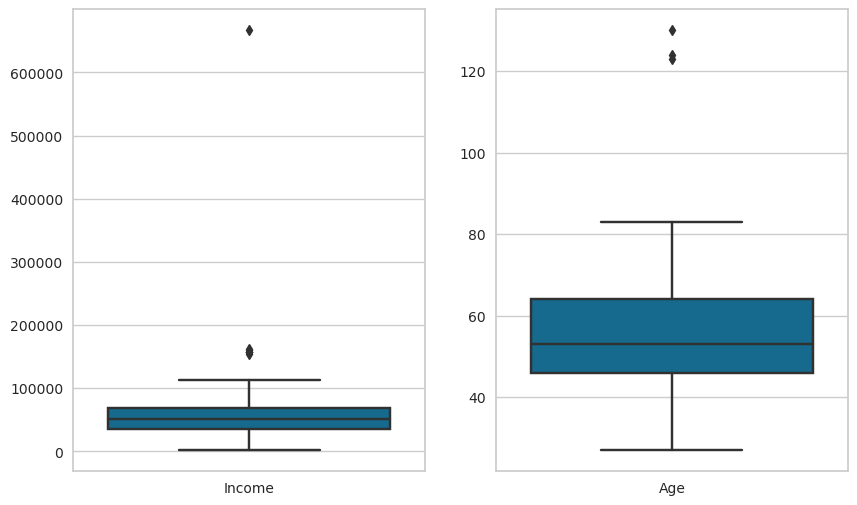

In [27]:
fig,ax = plt.subplots(1,2,figsize=(10,6))
plt.subplot(1,2,1)
sns.boxplot(df[["Income"]])

plt.subplot(1,2,2)
sns.boxplot(df[["Age"]])
plt.show()


Both Income and Age columns have outliers. Let's remove them.

In [28]:
cols = ["Income","Age"]

for i in cols:
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)
    iqr = q3-q1
    
    outliers = df[(df[i]<(q1-1.5*iqr)) | (df[i]>(q3+1.5*iqr))]
    
    #remove the outliers
    df = df[~((df[i]<(q1-1.5*iqr)) | (df[i]>(q3+1.5*iqr)))]

In [29]:
print("Remaining rows :",len(df))

Remaining rows : 2205


### **Label Encoding**

Label encoding the categorical features _ Education and Living_Status.


In [30]:
le = LabelEncoder()
df["Education"] = le.fit_transform(df["Education"])
df["Living_Status"] = le.fit_transform(df['Living_Status'])

In [31]:
df.dtypes

Education                int64
Income                 float64
Kidhome                  int64
Teenhome                 int64
Recency                  int64
wines                    int64
fruits                   int64
meat                     int64
fish                     int64
sweet                    int64
gold                     int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Response                 int64
Customer_for             int64
Living_Status            int64
Spent                    int64
Children                 int64
Is_parent                int64
Family_size              int64
Age                      int64
dtype: object

Now all columns are in numerical datatype.

### **Scaling the Features**

Let us create a copy of our data before proceeding further.

In [32]:
ds = df.copy()

In [33]:
sc = StandardScaler()
scaled_ds = sc.fit_transform(ds)
scaled_ds = pd.DataFrame(scaled_ds, columns = ds.columns)

In [34]:
scaled_ds.head()

,Education,Income,Kidhome,Teenhome,Recency,wines,fruits,meat,fish,sweet,...,AcceptedCmp2,Complain,Response,Customer_for,Living_Status,Spent,Children,Is_parent,Family_size,Age
0,-0.892338,0.314651,-0.823405,-0.930767,0.310830,0.974566,1.548614,1.748400,2.449154,1.480301,...,-0.117444,-0.095673,2.370996,1.974128,-1.347625,1.679323,-1.266589,-1.58466,-1.759012,1.017189
1,-0.892338,-0.254877,1.038757,0.906602,-0.380600,-0.874776,-0.638664,-0.731678,-0.652345,-0.635399,...,-0.117444,-0.095673,-0.421764,-1.664957,-1.347625,-0.963897,1.403420,0.63105,0.448513,1.273530
2,-0.892338,0.965354,-0.823405,-0.930767,-0.795458,0.355155,0.568110,-0.175957,1.336263,-0.149031,...,-0.117444,-0.095673,-0.421764,-0.172330,0.742046,0.281242,-1.266589,-1.58466,-0.655250,0.333612
3,-0.892338,-1.206087,1.038757,-0.930767,-0.795458,-0.874776,-0.563241,-0.667380,-0.506392,-0.586763,...,-0.117444,-0.095673,-0.421764,-1.923048,0.742046,-0.920675,0.068415,0.63105,0.448513,-1.289883
4,0.571654,0.322136,1.038757,-0.930767,1.555404,-0.394659,0.417263,-0.217292,0.150396,-0.003121,...,-0.117444,-0.095673,-0.421764,-0.821859,0.742046,-0.307248,0.068415,0.63105,0.448513,-1.033542


### **Dimensionality Reduction**

In this problem, there are many factors on the basis of which the final classification will be done. These factors are basically attributes or features. The higher the number of features, the harder it is to work with it. Many of these features are correlated, and hence redundant. This is why I will be performing dimensionality reduction on the selected features before putting them through a classifier.

Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss.

In [35]:
pca = PCA(n_components=3)
ds_pca = pca.fit_transform(scaled_ds)


In [36]:
pca.explained_variance_ratio_

array([0.29681411, 0.09861523, 0.06414898])

In [37]:
ds_pca = pd.DataFrame(ds_pca, columns=["Col1",'Col2','Col3'])
ds_pca

,Col1,Col2,Col3
0,4.985318,-0.280005,0.220997
1,-2.943559,0.006764,-0.457787
2,2.379949,-0.727560,-1.217446
3,-2.765551,-1.548292,-0.144950
4,-0.778496,0.208006,-0.691303
...,...,...,...
2200,2.102198,2.360711,-1.181221
2201,-2.527673,4.011489,1.196274
2202,2.737974,-1.431161,0.810865
2203,1.325453,1.681696,-1.361807


### **Clustering**


Now that I have reduced the attributes to three dimensions, I will be performing clustering via Agglomerative clustering and KMeans.

#### **Agglomerative Clustering**

Let us draw the dendrogram for our datapoints.

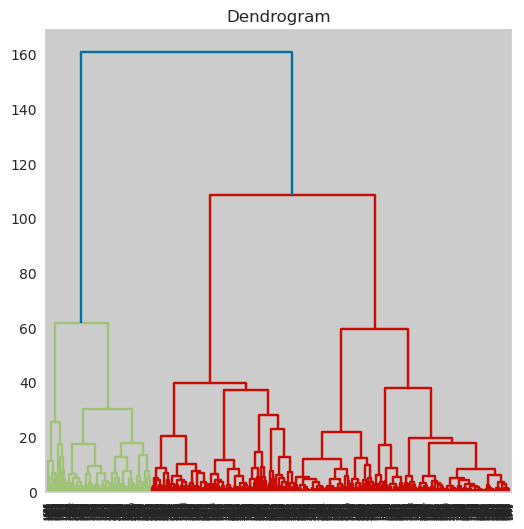

In [38]:
plt.figure(figsize=(6,6))
plt.title("Dendrogram")
shc.dendrogram(shc.linkage(ds_pca, method = 'ward'))
plt.show()

Check the Silhouette score for the clusters formed.

In [39]:
silhouette_scores = []

for k in range(2,8):
    silhouette_scores.append(silhouette_score(ds_pca, AgglomerativeClustering(n_clusters = k).fit_predict(ds_pca)))

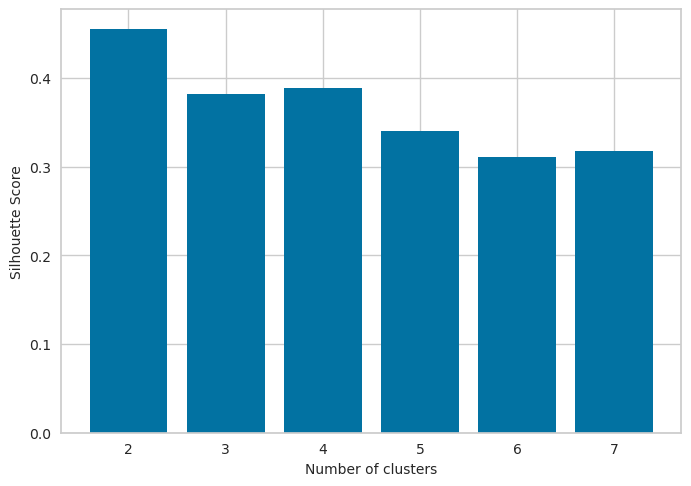

In [40]:
k = [2, 3, 4, 5, 6,7] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show()

I am choosing 5 as the optimal no of clusters.

In [41]:
agg = AgglomerativeClustering(n_clusters=5)
y_pred_ag = agg.fit_predict(ds_pca)
y_pred_ag

array([1, 4, 1, ..., 1, 0, 4])

In [42]:
ds_pca["Cluster_ac"] = y_pred_ag

#### **Plot of Clusters Formed**

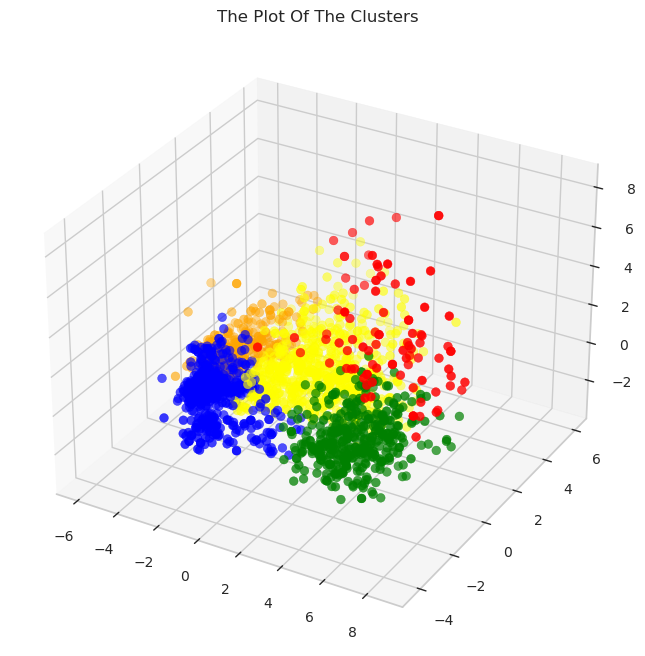

In [43]:
x = ds_pca["Col1"]
y = ds_pca["Col2"]
z = ds_pca["Col3"]

cmap = colors.ListedColormap(['yellow','green','blue','red','orange'])

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=ds_pca["Cluster_ac"], marker='o',cmap=cmap)
ax.set_title("The Plot Of The Clusters")
plt.show()

#### **KMeans**

Draw the Elbow graph to find the optimal number of clusters.

Elbow Method to determine the number of clusters to be formed:


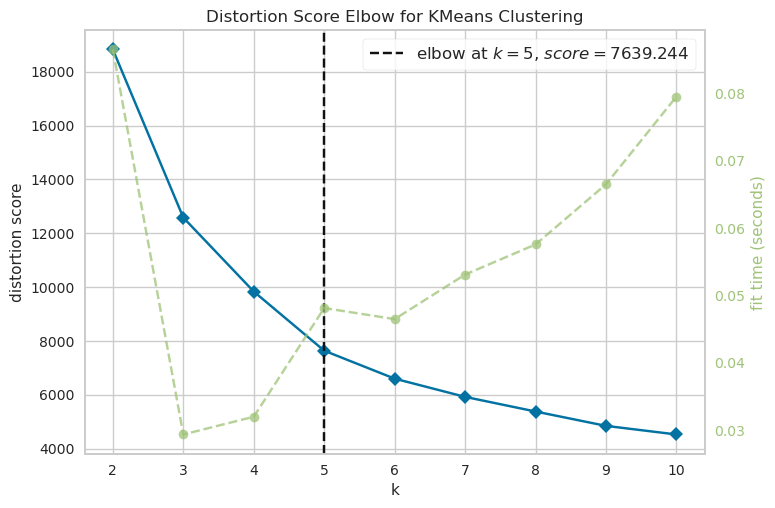

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [44]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(ds_pca)
Elbow_M.show()

In [45]:
km = KMeans(n_clusters=5)
y_pred = km.fit_predict(ds_pca)
y_pred

array([4, 0, 4, ..., 4, 2, 0], dtype=int32)

In [46]:
ds_pca["Cluster"] = y_pred
ds_pca

,Col1,Col2,Col3,Cluster_ac,Cluster
0,4.985318,-0.280005,0.220997,1,4
1,-2.943559,0.006764,-0.457787,4,0
2,2.379949,-0.727560,-1.217446,1,4
3,-2.765551,-1.548292,-0.144950,2,3
4,-0.778496,0.208006,-0.691303,0,2
...,...,...,...,...,...
2200,2.102198,2.360711,-1.181221,0,2
2201,-2.527673,4.011489,1.196274,0,2
2202,2.737974,-1.431161,0.810865,1,4
2203,1.325453,1.681696,-1.361807,0,2


#### **Plot of the Clusters Formed**

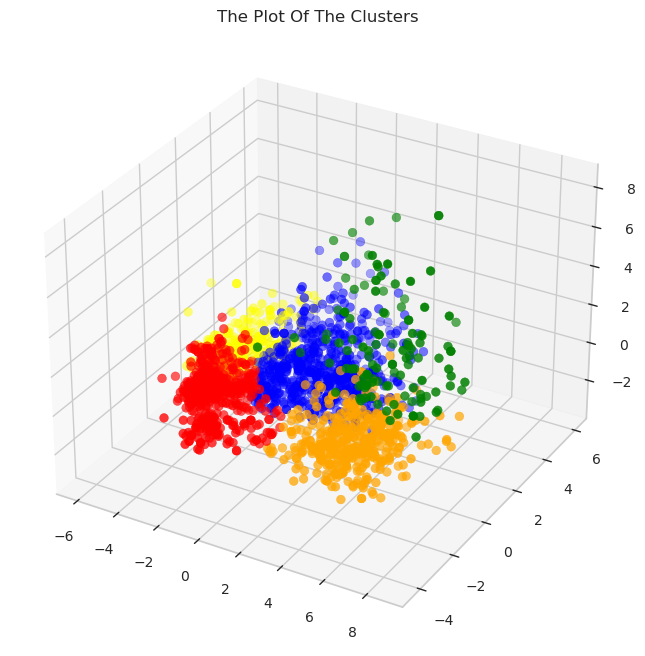

In [47]:
x = ds_pca["Col1"]
y = ds_pca["Col2"]
z = ds_pca["Col3"]

cmap = colors.ListedColormap(['yellow','green','blue','red','orange'])

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=ds_pca["Cluster"], marker='o',cmap=cmap)
ax.set_title("The Plot Of The Clusters")
plt.show()

#### **Create Cluster Column**

In [48]:
df["Cluster"] = y_pred
df.head()

,Education,Income,Kidhome,Teenhome,Recency,wines,fruits,meat,fish,sweet,...,Complain,Response,Customer_for,Living_Status,Spent,Children,Is_parent,Family_size,Age,Cluster
0,0,58138.0,0,0,58,635,88,546,172,88,...,0,1,971,0,1617,0,0,1,66,4
1,0,46344.0,1,1,38,11,1,6,2,1,...,0,0,125,0,27,2,1,3,69,0
2,0,71613.0,0,0,26,426,49,127,111,21,...,0,0,472,1,776,0,0,2,58,4
3,0,26646.0,1,0,26,11,4,20,10,3,...,0,0,65,1,53,1,1,3,39,3
4,1,58293.0,1,0,94,173,43,118,46,27,...,0,0,321,1,422,1,1,3,42,2


### **Evaluating Models**

The purpose of this section is to study the patterns in the clusters formed and determine the nature of the cluster patterns.

#### **Distribution of Clusters**

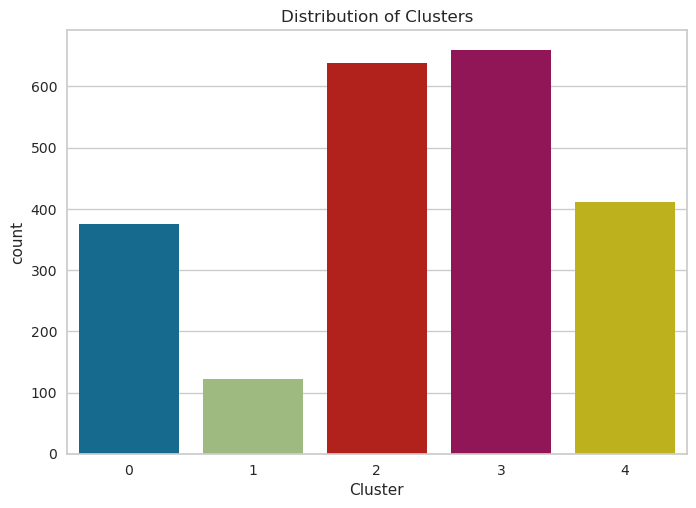

In [49]:
sns.countplot(x=df["Cluster"],data=df)
plt.title("Distribution of Clusters")
plt.show()

**Cluster3>Cluster2>Cluster4>Cluster0>Cluster1** in terms of number of customers.

#### **Cluster Profile basd on Income and Spending**

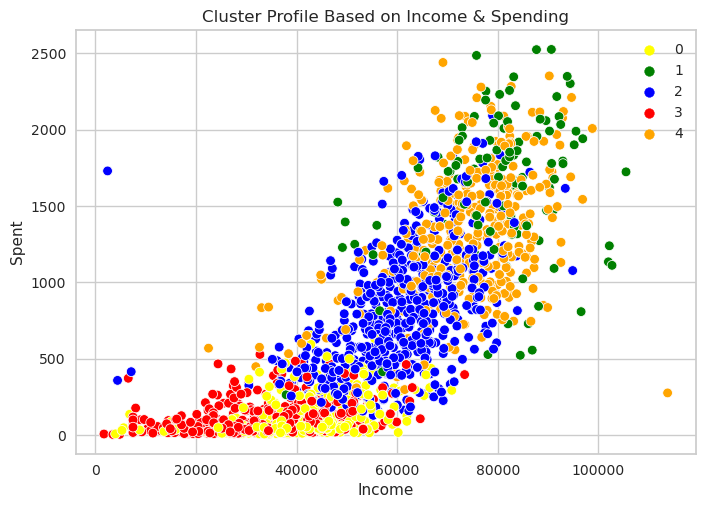

In [50]:
sns.scatterplot(data=df, x='Income',y='Spent',hue='Cluster',palette=cmap)
plt.title('Cluster Profile Based on Income & Spending')
plt.legend()
plt.show()

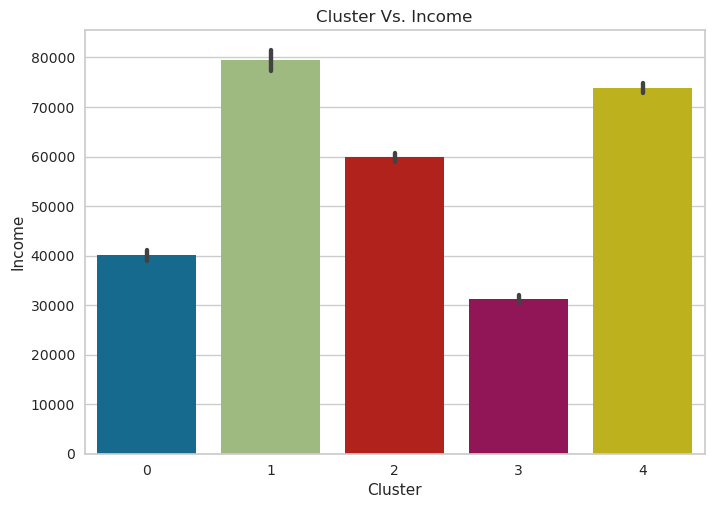

In [59]:
sns.barplot(x='Cluster',y='Income',data=df)
plt.title("Cluster Vs. Income")
plt.show()

**Cluster1>Cluster4>Cluster2>Cluster0>Cluster3** in terms of Income.

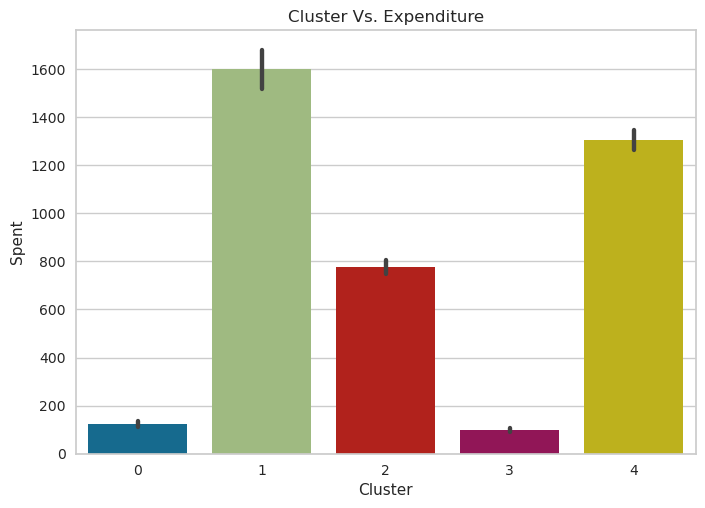

In [60]:
sns.barplot(x='Cluster',y='Spent',data=df)
plt.title("Cluster Vs. Expenditure")
plt.show()

**Cluster1>Cluster4>Cluster2>Cluster0>Cluster3** in terms of Expenditure. Same as Income.

**Insights**

* Cluster 0 - Fourth highest Income and Spending cluster
* Cluster 1 - Cluster with highest Income and Spending cluster
* Cluster 2 - Third highest Income and Spending cluster
* Cluster 3 - Least Highest Income and Spending cluster
* Cluster 4 - Second Highest Income and Spending cluster


#### **Promotions Accepted Vs Cluster**

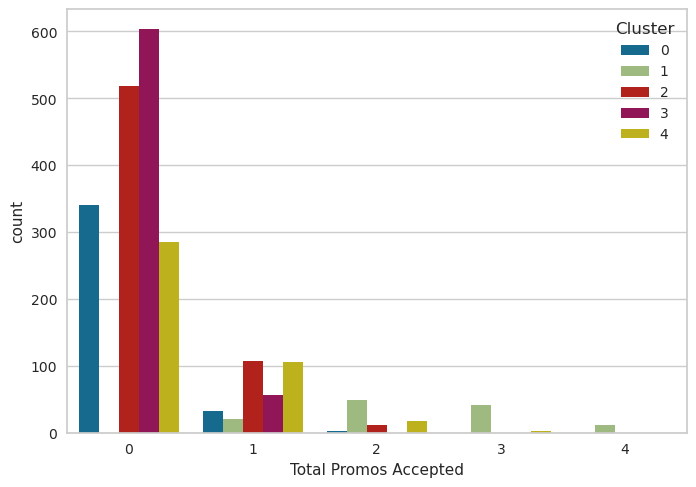

In [53]:
df["Total Promos Accepted"] = df['AcceptedCmp3']+ df['AcceptedCmp4']+ df['AcceptedCmp5']+df['AcceptedCmp1']+ df['AcceptedCmp2']
sns.countplot(data=df, x='Total Promos Accepted',hue='Cluster')
plt.show()

**Insights**

* There has not been an overwhelming response to the campaigns so far. 
* Very few participants overall. Moreover, not a single cluster has taken part in all 5 of them. 
* Perhaps better-targeted and well-planned campaigns are required to boost sales.

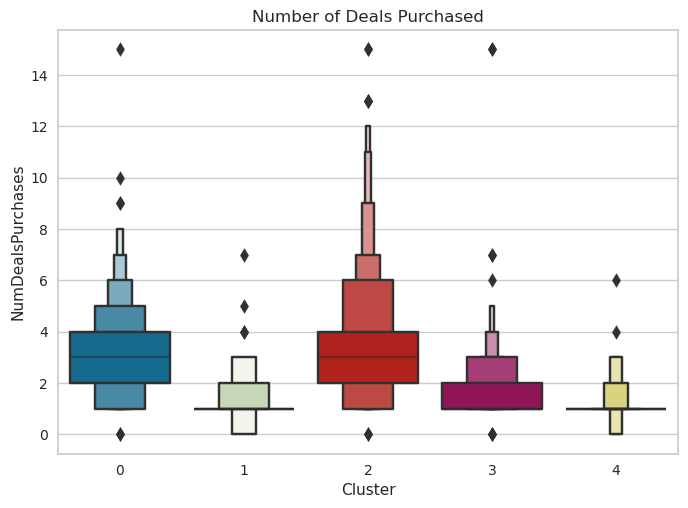

In [54]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=df["NumDealsPurchases"],x=df["Cluster"])
pl.set_title("Number of Deals Purchased")
plt.show()

**Insights**

* Unlike campaigns, the deals offered did well.
* It has best outcome with cluster 2 and cluster 0.
* However, our star customers cluster 1 are not much into the deals. 

### **Profiling**

Now that we have formed the clusters and looked at their purchasing habits. Let us see who all are there in these clusters. For that, we will be profiling the clusters formed and come to a conclusion about who is our star customer and who needs more attention from the retail store's marketing team.

To decide that I will be plotting some of the features that are indicative of the customer's personal traits in light of the cluster they are in. On the basis of the outcomes, I will be arriving at the conclusions.

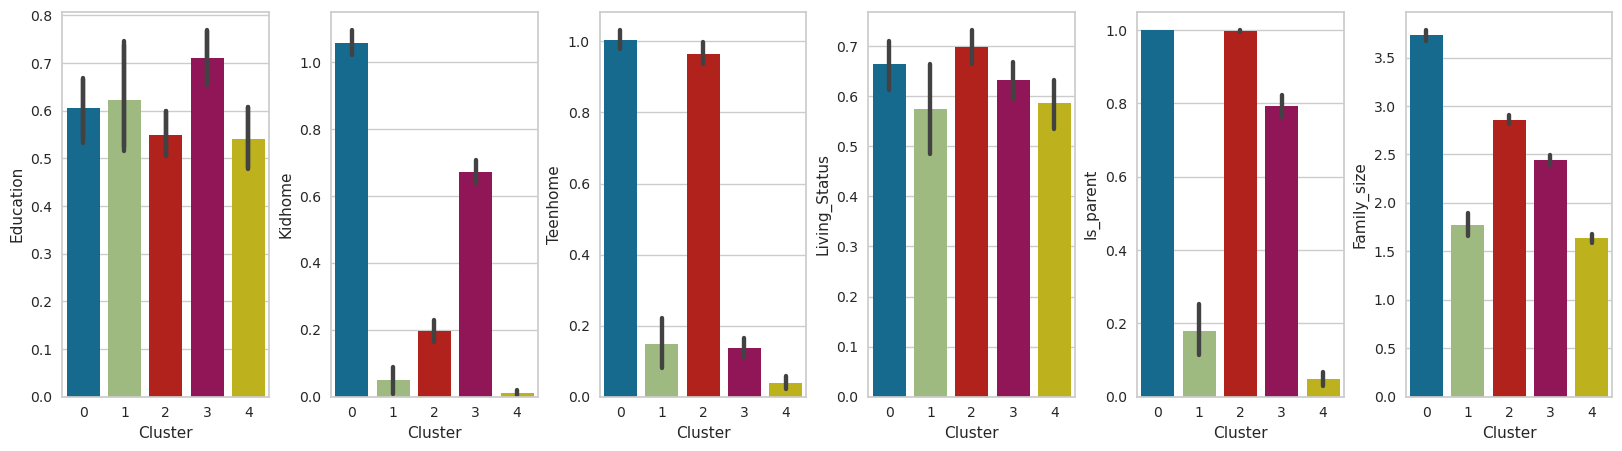

In [55]:

fig,ax = plt.subplots(1,6,figsize=(20,5))
fig.subplots_adjust(wspace=0.3)


plt.subplot(1,6,1)
sns.barplot(data=df, x='Cluster', y="Education")

plt.subplot(1,6,2)
sns.barplot(data=df, x='Cluster', y="Kidhome")

plt.subplot(1,6,3)
sns.barplot(data=df, x='Cluster', y="Teenhome")

plt.subplot(1,6,4)
sns.barplot(data=df, x='Cluster', y="Living_Status")

plt.subplot(1,6,5)
sns.barplot(data=df, x='Cluster', y="Is_parent")

plt.subplot(1,6,6)
sns.barplot(data=df, x='Cluster', y="Family_size")

plt.subplot(1,6,1)
sns.barplot(data=df, x='Cluster', y="Education")

plt.show()

In [56]:
df.groupby('Cluster').mean()[['Education','Kidhome', 'Teenhome','Age',
       'Living_Status', 'Children', 'Is_parent', 'Family_size']]

,Education,Kidhome,Teenhome,Age,Living_Status,Children,Is_parent,Family_size
Cluster,,,,,,,,
0,0.605333,1.058667,1.005333,57.733333,0.664000,2.064000,1.000000,3.728000
1,0.622951,0.049180,0.147541,51.647541,0.573770,0.196721,0.180328,1.770492
2,0.548589,0.195925,0.965517,57.826019,0.697492,1.161442,0.998433,2.858934
3,0.711684,0.672231,0.136571,47.808801,0.632777,0.808801,0.793627,2.441578
4,0.540146,0.009732,0.038929,55.793187,0.586375,0.048662,0.048662,1.635036


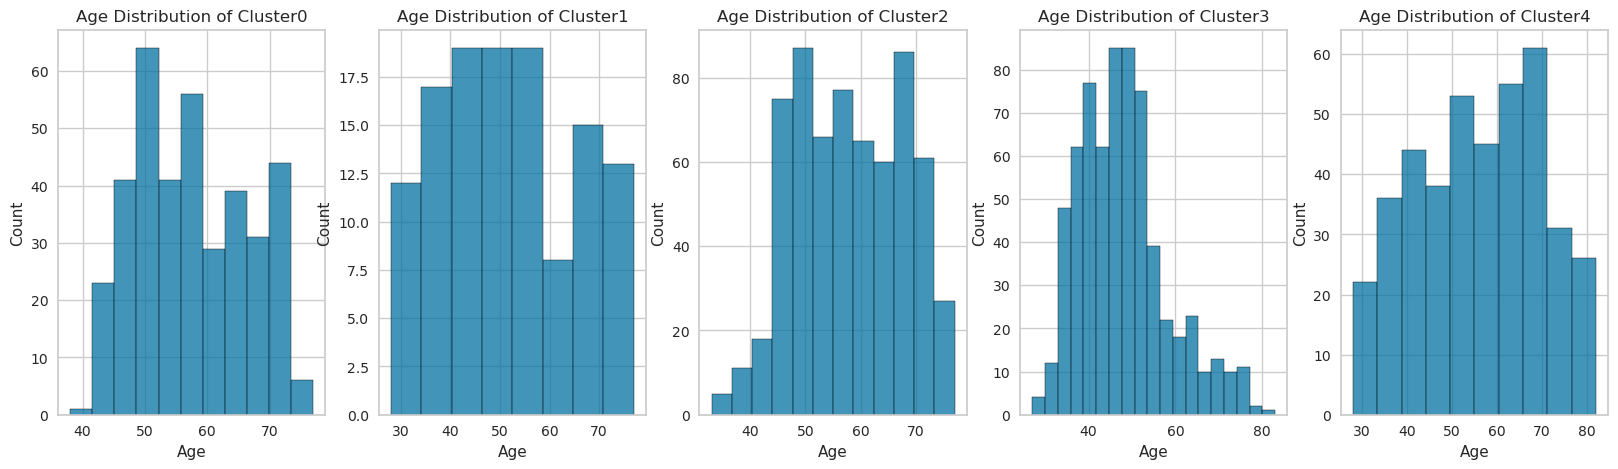

In [57]:
fig,ax = plt.subplots(1,5,figsize=(20,5))

plt.subplot(1,5,1)
sns.histplot(data=df.loc[df["Cluster"]==0],x='Age')
plt.title("Age Distribution of Cluster%d"%0)


plt.subplot(1,5,2)
sns.histplot(data=df.loc[df["Cluster"]==1],x='Age')
plt.title("Age Distribution of Cluster%d"%1)
cluster = [0,1,2,3,4]

plt.subplot(1,5,3)
sns.histplot(data=df.loc[df["Cluster"]==2],x='Age')
plt.title("Age Distribution of Cluster%d"%2)

plt.subplot(1,5,4)
sns.histplot(data=df.loc[df["Cluster"]==3],x='Age')
plt.title("Age Distribution of Cluster%d"%3)

plt.subplot(1,5,5)
sns.histplot(data=df.loc[df["Cluster"]==4],x='Age')
plt.title("Age Distribution of Cluster%d"%4)


plt.show()

In [58]:
col = ['Education','Kidhome', 'Teenhome',
       'Living_Status', 'Children', 'Is_parent', 'Family_size']
for i in cluster:
    
    print("CLUSTER",i)
    for j in col:
        data = df[df["Cluster"] == i]
            
        print(data[j].value_counts())
        
       

CLUSTER 0
0    181
1    161
2     33
Name: Education, dtype: int64
1    325
2     36
0     14
Name: Kidhome, dtype: int64
1    347
2     15
0     13
Name: Teenhome, dtype: int64
1    249
0    126
Name: Living_Status, dtype: int64
2    327
3     36
1     12
Name: Children, dtype: int64
1    375
Name: Is_parent, dtype: int64
4    232
3    121
5     21
2      1
Name: Family_size, dtype: int64
CLUSTER 1
1    58
0    55
2     9
Name: Education, dtype: int64
0    116
1      6
Name: Kidhome, dtype: int64
0    105
1     16
2      1
Name: Teenhome, dtype: int64
1    70
0    52
Name: Living_Status, dtype: int64
0    100
1     20
2      2
Name: Children, dtype: int64
0    100
1     22
Name: Is_parent, dtype: int64
2    58
1    46
3    18
Name: Family_size, dtype: int64
CLUSTER 2
0    333
1    260
2     45
Name: Education, dtype: int64
0    519
1    113
2      6
Name: Kidhome, dtype: int64
1    546
0     57
2     35
Name: Teenhome, dtype: int64
1    445
0    193
Name: Living_Status, dtype: int64
1

**CLUSTER 0**
* Average Age - 57 years
* Customers in this cluster is definitely a parent.
* Majority have Teenagers in their home.
* Few people live alone.
* Average family size is 4.

**CLUSTER 1**
* Average Age - 51 years
* Very few parents. (Out of 122 only 22 customers are parents.)
* Average Family Size - 2

**CLUSTER 2**
* Average Age - 57 years
* Except 1 all others are parents.
* More than half of the customers have members in the teenage group.
* Average Family Size - 3

**CLUSTER 3**
* Average Age - 47
* 66% Customers have atleast 1 kid.
* Majority customers are parents.
* Few of them have teenagers in their home.
* Average Family Size - 2

**CLUSTER 4**
* Average Age - 55
* 95% customers in this group are not parents.
* Only 0.97% have kids.
* Most of them live with a partner.
* Average Family Size - 2

### **Conclusion**

In this project, I performed unsupervised clustering. I did use dimensionality reduction followed by agglomerative clustering and KMeans clustering. I came up with 5 clusters and further used them in profiling customers in clusters according to their family structures and income/spending. This can be used in planning better marketing strategies and targeted campaigning.